<a href="https://colab.research.google.com/github/jayanth142006/potato-disease-classification-models/blob/main/ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/content/drive/MyDrive/potato_dis_aug'
img_size = (224, 224)
batch_size = 32
num_classes = 7  # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5452 images belonging to 7 classes.
Found 1361 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Count total layers
print(f"Total number of layers: {len(base_model.layers)}")

# Optional: Print all layer names
for i, layer in enumerate(base_model.layers):
    print(f"{i+1}: {layer.name} ({layer.__class__.__name__})")


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total number of layers: 190
1: input_layer (InputLayer)
2: conv1_pad (ZeroPadding2D)
3: conv1_conv (Conv2D)
4: pool1_pad (ZeroPadding2D)
5: pool1_pool (MaxPooling2D)
6: conv2_block1_preact_bn (BatchNormalization)
7: conv2_block1_preact_relu (Activation)
8: conv2_block1_1_conv (Conv2D)
9: conv2_block1_1_bn (BatchNormalization)
10: conv2_block1_1_relu (Activation)
11: conv2_block1_2_pad (ZeroPadding2D)
12: conv2_block1_2_conv (Conv2D)
13: conv2_block1_2_bn (BatchNormalization)
14: conv2_block1_2_relu (Activation)
15: conv2_block1_0_conv (Conv2D)
16: conv2_block1_3_conv (Conv2D)
17: conv2_block1_out (Add)
18: conv2_block2_preact_bn (BatchNormalization)
19: conv2_block2_preact_relu (Activation)
20: conv2_block2_1_conv (Conv2D)
21: conv2_block2_1_bn (BatchNormalization)
22: conv2_block2_1_relu (Activation)
23: conv2_block2_2_pad (ZeroPadding2D)
24: conv2_block2_2_conv (Conv2D)
25: conv2_block2_2_bn (BatchNormalization)
26: conv2_block2_2_re

In [ ]:
from tensorflow.keras.applications import ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3399 - loss: 1.7764 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 2377s 14s/step - accuracy: 0.3403 - loss: 1.7752 - val_accuracy: 0.4960 - val_loss: 1.3036
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 158s 923ms/step - accuracy: 0.5065 - loss: 1.2800 - val_accuracy: 0.6289 - val_loss: 1.0525
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 161s 941ms/step - accuracy: 0.5602 - loss: 1.1700 - val_accuracy: 0.6370 - val_loss: 1.0235
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 155s 907ms/step - accuracy: 0.5671 - loss: 1.1225 - val_accuracy: 0.6488 - val_loss: 0.9663
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 159s 927ms/step - accuracy: 0.6027 - loss: 1.0484 - val_accuracy: 0.6716 - val_loss: 0.8959
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 198s 903ms/step - accuracy: 0.6048 - loss: 1.0746 - val_accuracy: 0.6591 - val_loss: 0.9339
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 157s 916ms/step - accuracy: 0.6203 - loss: 1.0080 - val_accuracy: 0.6745 - val_loss: 0.8924
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 157s 921ms/step - accuracy: 0.6254 - loss: 0.981

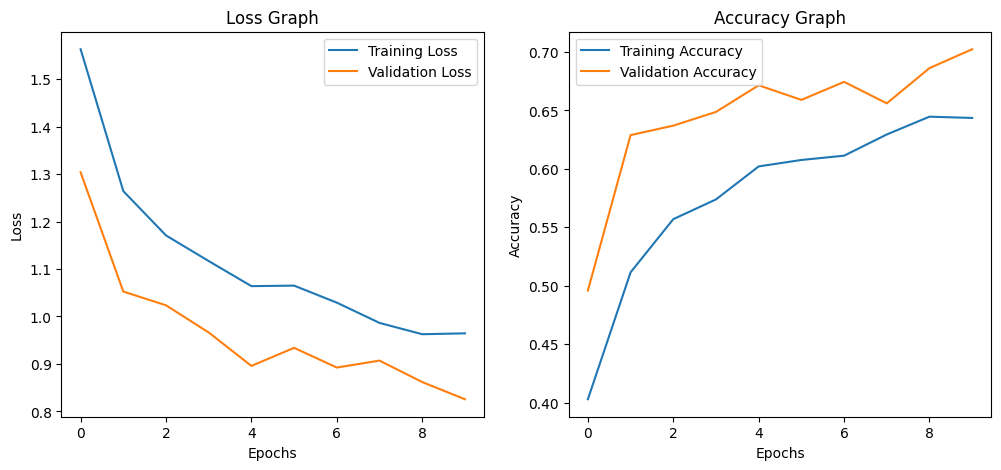

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 529ms/step
Before Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.94      0.83      0.88       226
       Fungi       0.65      0.68      0.66       294
     Healthy       0.47      0.85      0.60       118
    Nematode       0.93      0.91      0.92       132
        Pest       0.65      0.50      0.56       240
 Phytopthora       0.74      0.63      0.68       137
       Virus       0.68      0.68      0.68       214

    accuracy                           0.70      1361
   macro avg       0.72      0.72      0.71      1361
weighted avg       0.72      0.70      0.71      1361



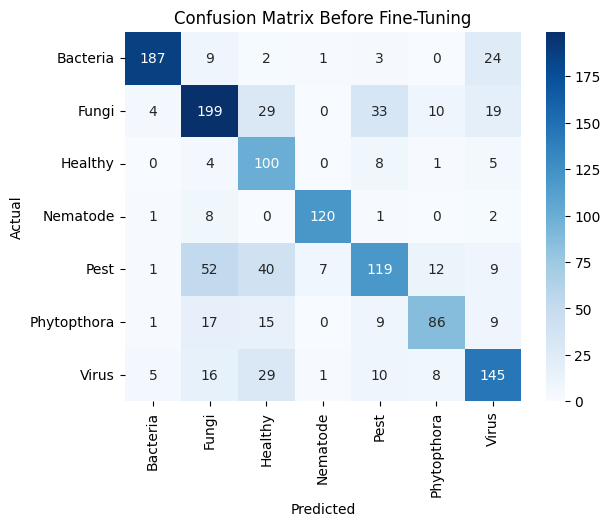

In [ ]:
# Evaluate Model
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:140]:
    layer.trainable = False
for layer in base_model.layers[140:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6454 - loss: 1.0084 - val_accuracy: 0.7597 - val_loss: 0.6514
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.7815 - loss: 0.6171 - val_accuracy: 0.8332 - val_loss: 0.4536
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 159s 933ms/step - accuracy: 0.8369 - loss: 0.4680 - val_accuracy: 0.8193 - val_loss: 0.5280
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 155s 907ms/step - accuracy: 0.8585 - loss: 0.4202 - val_accuracy: 0.8597 - val_loss: 0.4218
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 160s 937ms/step - accuracy: 0.8823 - loss: 0.3460 - val_accuracy: 0.8876 - val_loss: 0.3455
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 161s 941ms/step - accuracy: 0.9022 - loss: 0.2936 - val_accuracy: 0.9052 - val_loss: 0.2850
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 158s 925ms/step - accuracy: 0.9094 - loss: 0.2603 - val_accuracy: 0.9140 - val_loss: 0.2368
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 158s 923ms/step - accuracy: 0.9226 - loss:

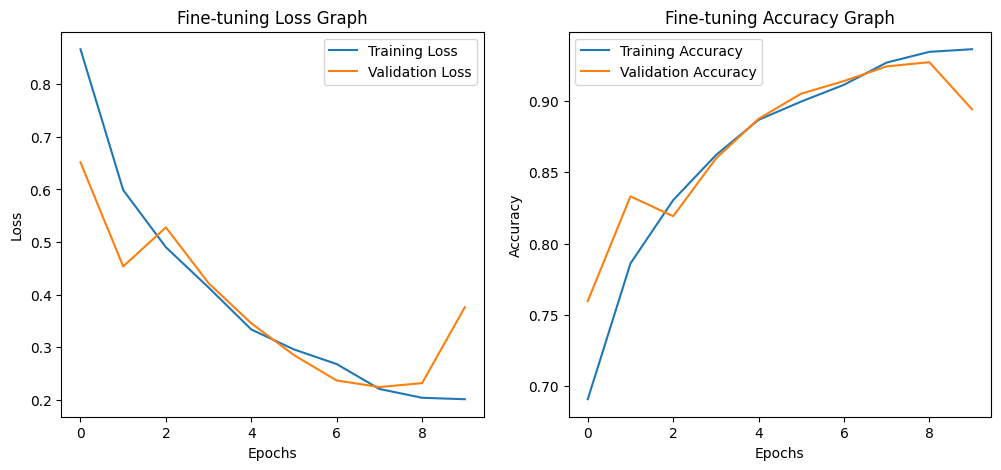

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 542ms/step
After Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.96      1.00      0.98       226
       Fungi       0.88      0.97      0.92       294
     Healthy       0.79      1.00      0.88       118
    Nematode       0.99      1.00      0.99       132
        Pest       0.96      0.78      0.86       240
 Phytopthora       0.96      0.86      0.91       137
       Virus       0.95      0.90      0.92       214

    accuracy                           0.92      1361
   macro avg       0.93      0.93      0.92      1361
weighted avg       0.93      0.92      0.92      1361



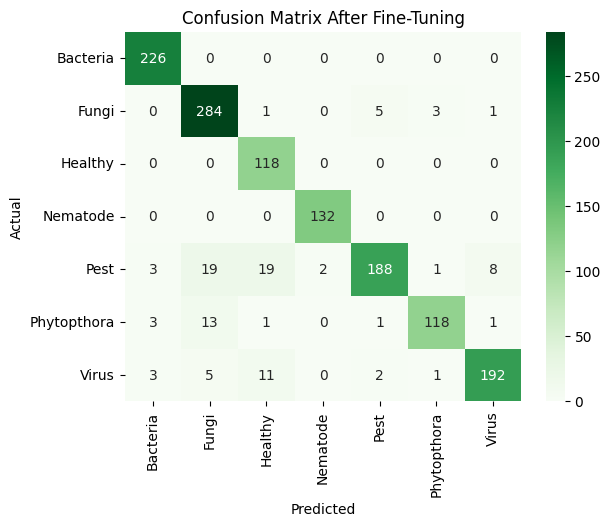

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()